In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

# if "google.colab" in sys.modules:
    # !sudo add-apt-repository -y ppa:deadsnakes/ppa
    # !sudo apt-get -y update
    # !sudo apt-get -y install python3.9
    # !sudo apt-get -y install python3.9-dev
    # !sudo apt-get -y install python3-pip
    # !sudo apt-get -y install python3.9-distutils
    # !python3.9 -m pip install --upgrade setuptools
    # !python3.9 -m pip install --upgrade pip
    # !python3.9 -m pip install --upgrade distlib

    # !sudo update-alternatives --set python /usr/bin/python3.9
    # !sudo ln -sf /usr/bin/python /usr/local/bin/python

    # #install python 3.9
    # !sudo apt-get update -y
    # !sudo apt-get install python3.9

    # #change alternatives
    # !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
    # !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

    # !python3.9 setup.py
    
    # !pip uninstall lightgbm -y
    # !pip install lightgbm==3.3.1
    # !pip uninstall catboost -y
    # !pip install catboost==1.0.6
    # !pip install Levenshtein
    # !pip uninstall pandas -y
    # !pip install pandas==1.4.1

import os
import gc
import time
import random
import pickle
# import Levenshtein
import difflib
import joblib
import multiprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
# import lightgbm as lgb
# from catboost import CatBoost
# from catboost import Pool
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [ ]:
!pip install feather-format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import feather

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    PROCESSED_DIR = os.path.join(ROOT_DIR, 'processed_data')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
test_df = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    test_df = test_df[:10000]
    test_df = test_df.reset_index(drop = True)

In [ ]:
mix_embedding_feat30 = np.load(os.path.join(CFG.PROCESSED_DIR, "mix_embedding_feat30.npy"))
mix_embedding_feat30.shape

(1138812, 256)

In [ ]:
if CFG.is_debug:
    mix_embedding_feat30 = mix_embedding_feat30[:10000]

In [ ]:
pred_df = pd.read_csv(os.path.join(CFG.PROCESSED_DIR, "pred31_score_and_rank.csv"))
pred_df.head()

,query_ix,candidate_ix,pred,rank,fold
0,6,903995,0.015949,1.0,0
1,6,305579,0.001998,2.0,0
2,6,238967,0.264468,3.0,0
3,6,786499,0.023800,4.0,0
4,6,549946,0.026928,5.0,0


In [ ]:
if CFG.is_debug:
    print(pred_df.shape)
    pred_df = pred_df[(pred_df['query_ix'] < 10000) & (pred_df['candidate_ix'] < 10000)]
    print(pred_df.shape)

In [ ]:
query_col = "query_ix"
candidate_col = "candidate_ix"
score_col = "pred"

In [ ]:
from itertools import groupby

class UnionFind():
    
    def __init__(self, N):
        self.parent = [-1] * N
        self.size = [1] * N
        
    def find(self, x):
        p = self.parent[x]
        if p == -1:
            return x
        p = self.find(p)
        self.parent[x] = p
        return p
    
    def unite(self, x, y):
        px = self.find(x)
        py = self.find(y)
        if px == py:
            return
        if self.size[px] < self.size[py]:
            px, py = py, px
        self.size[px] += self.size[py]
        self.parent[py] = px

In [ ]:
data_id_map = {v: i for i, v in enumerate(test_df["id"].values)}
test_df["ix"] = test_df["id"].map(data_id_map)
test_df["categories"] = test_df["categories"].fillna("")

In [ ]:
ix = test_df["ix"]

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

In [ ]:
id2poi = get_id2poi(test_df)
poi2ids = get_poi2ids(test_df)

In [ ]:
def normalize(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

def neighborhood_search(emb, thresh):
    mix_cossim = tf.einsum("nd,md->nm", tf.gather(emb, list(range(len(emb)))), emb)
    mix_cossim = np.array(mix_cossim)
    np.fill_diagonal(mix_cossim, np.ones(mix_cossim.shape[0]))
    match_index_lst = [np.where(mix_cossim[i] > thresh)[0] for i in range(emb.shape[0])]
    similarities_lst = [mix_cossim[i, match_index_lst[i]] for i in range(emb.shape[0])]
    return match_index_lst, similarities_lst


def blend_neighborhood(emb, match_index_lst, similarities_lst):
    new_emb = emb.copy()
    for i in range(emb.shape[0]):
        cur_emb = emb[match_index_lst[i]]
        weights = np.expand_dims(similarities_lst[i], 1)
        new_emb[i] = (cur_emb * weights).mean(axis=0)
    # new_emb = normalize(new_emb, axis=1)
    return new_emb

def iterative_neighborhood_blending(emb, threshes):
    for thresh in threshes:
        match_index_lst, similarities_lst = neighborhood_search(emb, thresh)
        emb = blend_neighborhood(emb, match_index_lst, similarities_lst)
    return match_index_lst

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

In [23]:
def objective(trial):
    threshold = trial.suggest_uniform('threshold', 0.93, 0.9301)
    pred_df_ = pred_df[pred_df['pred'] > threshold]

    submission_df = test_df[["id"]]
    submission_df["matches"] = test_df["id"]

    uft = UnionFind(len(test_df))

    for ix, nix in pred_df_[["query_ix", "candidate_ix"]].values:
        uft.unite(ix, nix)
    group_members = defaultdict(list)
    group_size = defaultdict(int)
    group_map = {}
    for i in range(len(test_df)):
        group_members[uft.find(i)].append(i)
        group_size[uft.find(i)] = uft.size[uft.find(i)]
        group_map[i] = uft.find(i)

    ids = []
    match_ids = []
    threshes_num = trial.suggest_int('threshes_num', 1, 1)
    threshes = [trial.suggest_uniform('thresh_' + str(i), 0.97, 1) for i in range(threshes_num)]

    for group_member in group_members.values():
        if len(group_member) == 1:
            ids.append(test_df.loc[group_member[0], 'id'])
            match_ids.append(test_df.loc[group_member[0], 'id'])
            continue
        group_member.sort()
        match_index_lst = iterative_neighborhood_blending(mix_embedding_feat30[group_member], [0.7, 0.8, 0.9])
        match_index_lst = [[group_member[x] for x in match_index] for match_index in match_index_lst]
        for i in range(len(group_member)):
            ids.append(test_df.loc[group_member[i], 'id'])
            match_ids.append(' '.join(test_df.loc[match_index_lst[i], 'id'].values))
    sub = pd.DataFrame()
    sub['id'] = ids
    sub['matches'] = match_ids
    sub.head()

    cv = get_score(submission_df)
    print("cv: " + str(cv))

    return cv

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-07-06 00:54:26,606] A new study created in memory with name: no-name-3280b13e-a492-465b-bedb-566794eb0560


KeyboardInterrupt: ignored

In [ ]:
study.best_params

In [ ]:
study.best_value

In [25]:
pred_df_ = pred_df[pred_df['pred'] > 0.93]
pred_df_.head()

,query_ix,candidate_ix,pred,rank,fold
36,7,22369,0.993669,5.0,0
128,31,689942,0.967751,1.0,0
160,32,994033,0.999901,1.0,0
192,36,51809,0.999953,1.0,0
224,43,983085,0.999979,1.0,0


In [29]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [30]:
cossims = []
for ix, nix in pred_df_[['query_ix', 'candidate_ix']].values:
    cossim = cos_sim(mix_embedding_feat30[ix], mix_embedding_feat30[nix])
    cossims.append(cossim)

(array([5.70000e+01, 8.72000e+02, 6.69800e+03, 2.52870e+04, 6.22970e+04,
        1.22730e+05, 1.86090e+05, 1.98965e+05, 1.47035e+05, 1.65220e+05]),
 array([-0.07195173,  0.03524347,  0.14243867,  0.24963386,  0.35682905,
         0.46402425,  0.57121944,  0.67841464,  0.78560984,  0.89280504,
         1.0000002 ], dtype=float32),
 <a list of 10 Patch objects>)

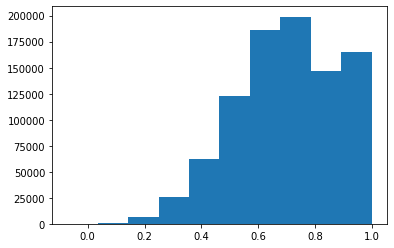

In [31]:
plt.hist(cossims)